In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from collections import Counter
import re
from useful_tools import ModelTester

In [2]:
with open('../datasets/sms_spam/SMSSpamCollection.txt') as infile:
    data = pd.read_csv(infile, delimiter='\t', header=-1)

data.columns = ['spam', 'message']
data['spam'] = (data['spam'] == 'spam').astype(int)

# Spam-filter

## Ord som trigger spam-filteret

In [24]:
# free_list = []
# winner_list =  []
# congrats_list = []
# adult_list = []
# attention_list = []
# ringtone_list = []

free_list = ['free']
winner_list =  ['winner', 'win', 'won', 'award', 'selected']
congrats_list = ['congrats', 'congratulations']
adult_list = ['xxx', 'babe', 'naked', 'dirty', 'flirty']
attention_list = ['urgent', 'attention', 'bonus', 'immediately']
ringtone_list = ['ringtone']

# Nye ord
# free_list += []
# winner_list +=  ['prize', 'www', 'awarded', 'cash']
# congrats_list +=  ['draw', 'free', 'claim', 'gift', 'guaranteed']
# adult_list += []
# attention_list += []
# ringtone_list +=  ['unsubscribe', 'subscription', 'subscribe']
 
variable_names = ['free', 'winner', 'congrats', 'adult', 'attention', 'ringtone']
lists = (free_list, winner_list, congrats_list, attention_list, ringtone_list)

spam_lists = dict(zip(variable_names, lists))

# spam_lists = {}
# for name, wordlist in zip(variable_names, lists):
#     spam_lists[name] = wordlist

## Sett variablene til å være 'nei' som standard

In [25]:
for name in variable_names:
    data[name] = 0

## Finnes ordene i meldingene?

Vi går gjennom alle meldingene, og setter variablene til 1 hvis minst ett ord fra lista finnes i meldingen. For eksempel, hvis "award" finnes i en melding, vil winner-variabelen til meldingen setter til 1. Til slutt printer vi de trigger-ordene som er mest vanlige.

In [26]:
counter = 0
word_counter = {}

for index, data_item in data.iterrows():
    message = data_item['message'].lower()
    
    for variable_name, word_list in spam_lists.items():
        for word in word_list:
            if word in message:
                word_counter[word] = word_counter.get(word, 0) + 1
        if any(word in message for word in word_list):
            counter += 1
            data.loc[index, variable_name] = 1
data.head()
Counter(word_counter).most_common()

[('free', 265),
 ('won', 167),
 ('win', 167),
 ('urgent', 69),
 ('award', 59),
 ('ringtone', 40),
 ('selected', 29),
 ('winner', 23),
 ('bonus', 21),
 ('congrats', 19),
 ('congratulations', 15),
 ('immediately', 10),
 ('attention', 1)]

## Oppdeling i trening- og testsett

Nå vil vi se om vi ut fra variablene vi satte kan finne ut om en melding er spam eller ikke. Først deler vi opp datasettet i trening- og testsett.

In [27]:
np.random.seed(190)
train, test = train_test_split(data, test_size=0.2)

x_train = train.drop(['spam', 'message'], axis=1)
y_train = train[['spam']]
x_test = test.drop(['spam', 'message'], axis=1)
y_test = test[['spam']]

tester = ModelTester(x_test, y_test)

In [28]:
train.head()

,spam,message,free,winner,congrats,adult,attention,ringtone
5067,0,I calls you later. Afternoon onwords mtnl serv...,0,0,0,0,0,0
533,0,Gudnite....tc...practice going on,0,0,0,0,0,0
4423,0,MMM ... Fuck .... Merry Christmas to me,0,0,0,0,0,0
1521,1,"URGENT! Your Mobile No was awarded a £2,000 Bo...",0,1,0,1,0,0
389,1,4mths half price Orange line rental & latest c...,1,0,0,0,0,0


# Besluttningstrær

Confusion matrix, without normalization


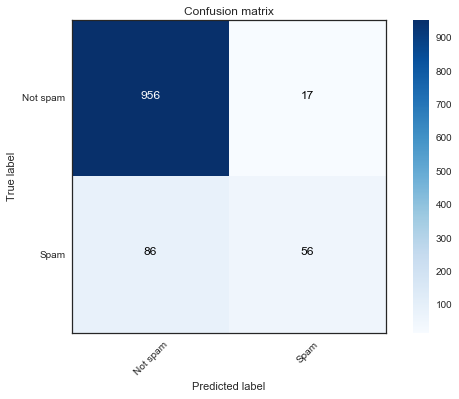

Accuracy:  90.7623318386 %


In [29]:


tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

tester.test_classifier(tree_model, ['Not spam', 'Spam'])

## Forbedring av filteret

In [9]:
def filter_data(df, include=[], exclude=[]):
    query_strings = []
    for name in include:
        query_strings.append('{name} == 1'.format(name=name))
    for name in exclude:
        query_strings.append('{name} == 0'.format(name=name))
        
    query_string = ' and '.join(query_strings)
    if query_string == '':
        return df
    
    return df.query(query_string)

In [10]:
def filter_training(include=[], exclude=[]):
    return filter_data(train, include, exclude)

In [11]:
def count_words(df):
    all_messages = ' '.join(df['message'].values).lower()
    words = re.findall(r'\w+', all_messages)
    counter = Counter(words)
    return counter

In [15]:
def compare_spam_words(df):
    df_spam = filter_data(df, ['spam'])
    df_no_spam = filter_data(df, exclude=['spam'])
    counter_spam = count_words(df_spam)
    counter_no_spam  = count_words(df_no_spam)
    
    result = []
    for key in set(counter_spam) | set(counter_no_spam):
        spam_count = counter_spam.get(key, 0)
        no_spam_count = counter_no_spam.get(key, 0)
    
        result.append({'word': key, 'spam_share': spam_count/(spam_count + no_spam_count),'spam_count': spam_count, 'not_spam_count': no_spam_count})

    result = pd.DataFrame(result, columns=['word', 'spam_share', 'spam_count', 'not_spam_count']).sort_values(['spam_share', 'spam_count'], ascending=[False, False])
    return result 
    
    

In [16]:
sorted_df = compare_spam_words(filter_training(include=[]))

In [17]:
print(sorted_df.to_string())

                                    word  spam_share  spam_count  not_spam_count
3392                               claim    1.000000         100               0
7592                               prize    1.000000          83               0
6337                                150p    1.000000          59               0
2052                          guaranteed    1.000000          48               0
364                                 tone    1.000000          46               0
1094                                  18    1.000000          42               0
7288                                 500    1.000000          39               0
119                                 1000    1.000000          38               0
6859                             awarded    1.000000          37               0
584                                   cs    1.000000          35               0
126                               150ppm    1.000000          30               0
2337                        